In [57]:
import json
import psycopg2
import time
import pandas as pd
from datetime import datetime
import numpy as np
import math
import pickle
import os
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [92]:
conn = psycopg2.connect(
  port = "5432",
  host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db"
)

In [93]:
q='''SELECT created_at as created, id as order_iD, total_price as order_amount, customer_id as user_id from orders WHERE
cancelled_at is NULL;
'''
e=pd.read_sql(q,conn)
# e = e[e['created'] >= '2023-01-01']

In [94]:
e['order_id'].nunique()

72873

In [95]:
# e=e[e['created']<='2023/12/31']
#e=e[e['created']>='2023/11/29']
#e.info()
e["user_id"].nunique()

44809

In [96]:
e['WeekCount']=e['created'].dt.strftime('%Y-w%U')

In [97]:
e=e.sort_values('created')
WeekList=e['WeekCount'].unique()
List=WeekList

In [98]:
e["New"] = 0
e['TrxnRank'] = e.groupby('user_id')['created'].rank(method='first')
e.loc[e['TrxnRank']==1,'New'] = 1

In [99]:
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)

In [102]:
e['AOV']=e['order_amount']/e['order_id'].nunique()

In [103]:
# e['OrderDate']=e['created'].dt.date
# e['OrderDate']=pd.to_datetime(k['OrderDate'])

x1=e.groupby('user_id').agg(
          LastDate=pd.NamedAgg(column='OrderDate', aggfunc= lambda x: x.nlargest(1).min()),
          FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Total_Order_Amount=pd.NamedAgg(column='order_amount', aggfunc='sum'),
          OrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
          MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean'),
          New=pd.NamedAgg(column='New',aggfunc='mean'),
          AOV=pd.NamedAgg(column='AOV',aggfunc='mean')
      ).reset_index()
globalmaxdate=e['OrderDate'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=np.nan
x1.loc[x1['Frequency']>1,"MaturityAge"]=(x1['LastDate']-x1['FirstDate']).dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)


In [104]:

r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['Frequency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score']=0
x1.loc[x1['MaturityAge'].notnull(),'m_score']= x1.loc[x1['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']

# def CohortLables_1(df):
#   if (df['New']==1 and df['AOV_score']>2):
#     return 'New&High Value'
#   elif (df['New']==1 and df['AOV_score']<=2):
#     return 'New&Low Value'
#   elif (df['New']<1 and df['AOV_score']<=2):
#     return 'Returning&Low Value'
#   else:
#     return 'Returning&High Value'

# def CohortLables_2(df):
#   if ((df['SumScore'] >= 18) and (df['Frequency']>1)):
#       return 'Champions'
#   elif ((df['m_score'] <=1) and (df['SumScore'] >= 10)and (df['SumScore'] < 18) and (df['r_score'] >1)):
#       return 'New&Potential'
#   elif ((df['m_score'] >1) and (df['SumScore'] >= 14)and (df['SumScore'] < 18)and (df['r_score'] >1)):
#       return 'Mature&Loyal'
#   elif ((df['m_score'] >1) and (df['SumScore'] >= 10)and (df['SumScore'] < 14)and (df['r_score'] >1)):
#       return 'Mature&Slow'
#   elif ((df['m_score'] <=1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
#       return 'New&Slow'
#   elif ((df['m_score'] >1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
#       return 'Mature&ChurnRisk'
#   else:
#       return 'Churned'

def CohortLables_3(df):
    if ((df['Frequency']==1) & (df['r_score']>2)):
        return "New"
    elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
        return 'Churned (Single Use Only)'
    elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
        return 'Recent & Loyals'
    elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
        return 'Champions'
    else:
        return 'Churned (Repeat Use)'

In [105]:
x1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44809 entries, 0 to 44808
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             44809 non-null  float64       
 1   LastDate            44809 non-null  datetime64[ns]
 2   FirstDate           44809 non-null  datetime64[ns]
 3   Frequency           44809 non-null  int64         
 4   Total_Order_Amount  44809 non-null  float64       
 5   OrderValue          44809 non-null  float64       
 6   MeanDaysDelta       44809 non-null  float64       
 7   MeanOVDelta         44809 non-null  float64       
 8   New                 44809 non-null  float64       
 9   AOV                 44809 non-null  float64       
 10  Recency             44809 non-null  int64         
 11  ActivatedQuater     44809 non-null  period[Q-DEC] 
 12  MaturityAge         8789 non-null   float64       
 13  r_score             44809 non-null  int64     

In [106]:
# totalordervalue
# totalordercount

In [107]:
x1["user_id"].nunique()

44809

In [108]:
count_customer = e['user_id'].nunique()
maxDate = e.OrderDate.max()
minDate = e.OrderDate.min()
no_of_days = maxDate - minDate
no_of_days.days
x1['CohortLabel'] = x1.apply(CohortLables_3, axis=1)
# if (count_customer<500 or no_of_days.days < 180):
#   x1['CohortLabel'] = x1.apply(CohortLables_1, axis=1)
# else:
#   x1['CohortLabel'] = x1.apply(CohortLables_2, axis=1)

In [109]:
segstats=x1.groupby(
  'CohortLabel'
).agg(
      Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
      Recency_in_Days=pd.NamedAgg(column='Recency', aggfunc='mean'),
      Average_Order_Frequency=pd.NamedAgg(column='Frequency', aggfunc='mean'),
      OrderValue=pd.NamedAgg(column='OrderValue', aggfunc='sum'),
      # Total_Order_Value=pd.NamedAgg(column='Total_Order_Value', aggfunc='sum'),
      #MeanDaysDelta=pd.NamedAgg(column='MeanDaysDelta', aggfunc='mean'),
      #MeanOVDelta=pd.NamedAgg(column='MeanOVDelta', aggfunc='mean'),
      #FrequencyperDeltaDays=pd.NamedAgg(column='FrequencyperDeltaDays', aggfunc='mean'),
    Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean'),
    OrderCount=pd.NamedAgg(column='Frequency', aggfunc='sum'),
).reset_index()
segstats["AOV"]=segstats['OrderValue']/segstats['OrderCount']
segstats['OrderValueMix']=segstats['OrderValue']/segstats['OrderValue'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()
segstats['AOV_Contribution']=segstats['OrderValue']/segstats['OrderCount'].sum()
segstats['OrderCountMix']=segstats['OrderCount']/segstats['OrderCount'].sum()

In [110]:
segstats

,CohortLabel,Users,Recency_in_Days,Average_Order_Frequency,OrderValue,Maturity,OrderCount,AOV,OrderValueMix,UsersMix,AOV_Contribution,OrderCountMix
0,Champions,2754,106.569717,4.286492,9987255.15,325.969862,11805,846.019072,0.238382,0.061461,157.911254,0.186652
1,Churned (Repeat Use),3538,528.041549,2.741379,8617290.51,158.938383,9699,888.472060,0.205683,0.078957,136.250364,0.153354
2,Churned (Single Use Only),18866,571.001749,1.000000,13900344.22,NaN,18866,736.793397,0.331782,0.421031,219.782187,0.298296
3,New,17154,114.202402,1.000000,6808555.20,NaN,17154,396.907730,0.162511,0.382825,107.651950,0.271227
4,Recent & Loyals,2497,96.764918,2.291550,2582595.60,24.066480,5722,451.344914,0.061643,0.055725,40.834133,0.090472


In [111]:
sum_row = segstats.sum(numeric_only=True)
segstats = pd.concat([segstats, sum_row.to_frame().T], ignore_index=True)
segstats.at[segstats.index[-1], 'CohortLabel'] = 'Overall'
segstats


,CohortLabel,Users,Recency_in_Days,Average_Order_Frequency,OrderValue,Maturity,OrderCount,AOV,OrderValueMix,UsersMix,AOV_Contribution,OrderCountMix
0,Champions,2754.0,106.569717,4.286492,9987255.15,325.969862,11805.0,846.019072,0.238382,0.061461,157.911254,0.186652
1,Churned (Repeat Use),3538.0,528.041549,2.741379,8617290.51,158.938383,9699.0,888.472060,0.205683,0.078957,136.250364,0.153354
2,Churned (Single Use Only),18866.0,571.001749,1.000000,13900344.22,NaN,18866.0,736.793397,0.331782,0.421031,219.782187,0.298296
3,New,17154.0,114.202402,1.000000,6808555.20,NaN,17154.0,396.907730,0.162511,0.382825,107.651950,0.271227
4,Recent & Loyals,2497.0,96.764918,2.291550,2582595.60,24.066480,5722.0,451.344914,0.061643,0.055725,40.834133,0.090472
5,Overall,44809.0,1416.580335,11.319422,41896040.68,508.974725,63246.0,3319.537173,1.000000,1.000000,662.429888,1.000000


In [112]:
def weighted_average_column(df, column_name, weights_column):
    data = df[column_name]
    weights = df[weights_column]

    if weights.sum() == 0:
        raise ValueError("Total weight must be greater than 0.")

    return (data * weights).sum() / weights.sum()

h = weighted_average_column(segstats, 'Maturity', 'Users')
# g = weighted_average_column(segstats, 'Frequency', 'Users')

In [121]:
segstats.loc[segstats['CohortLabel'] == 'Overall', 'Recency_in_Days'] = segstats['Recency_in_Days'].min()
segstats.loc[segstats['CohortLabel'] == 'Overall', 'Average_Order_Frequency'] = segstats['OrderCount'].sum()/segstats['Users'].sum()
segstats.loc[segstats['CohortLabel'] == 'Overall', 'AOV'] = segstats['OrderValue'].sum()/segstats['OrderCount'].sum()
segstats.loc[segstats['CohortLabel'] == 'Overall', 'Maturity'] = h
segstats.fillna(0)

,CohortLabel,Users,Recency_in_Days,Average_Order_Frequency,OrderValue,Maturity,OrderCount,AOV,OrderValueMix,UsersMix,AOV_Contribution,OrderCountMix
0,Champions,2754.0,106.569717,4.286492,9987255.15,325.969862,11805.0,846.019072,0.238382,0.061461,157.911254,0.186652
1,Churned (Repeat Use),3538.0,528.041549,2.741379,8617290.51,158.938383,9699.0,888.472060,0.205683,0.078957,136.250364,0.153354
2,Churned (Single Use Only),18866.0,571.001749,1.000000,13900344.22,0.000000,18866.0,736.793397,0.331782,0.421031,219.782187,0.298296
3,New,17154.0,114.202402,1.000000,6808555.20,0.000000,17154.0,396.907730,0.162511,0.382825,107.651950,0.271227
4,Recent & Loyals,2497.0,96.764918,2.291550,2582595.60,24.066480,5722.0,451.344914,0.061643,0.055725,40.834133,0.090472
5,Overall,44809.0,96.764918,1.411458,41896040.68,271.449792,63246.0,662.429888,1.000000,1.000000,662.429888,1.000000


In [122]:
# segstats.to_csv("Paakhi_Dsummaytf.csv", index=False)

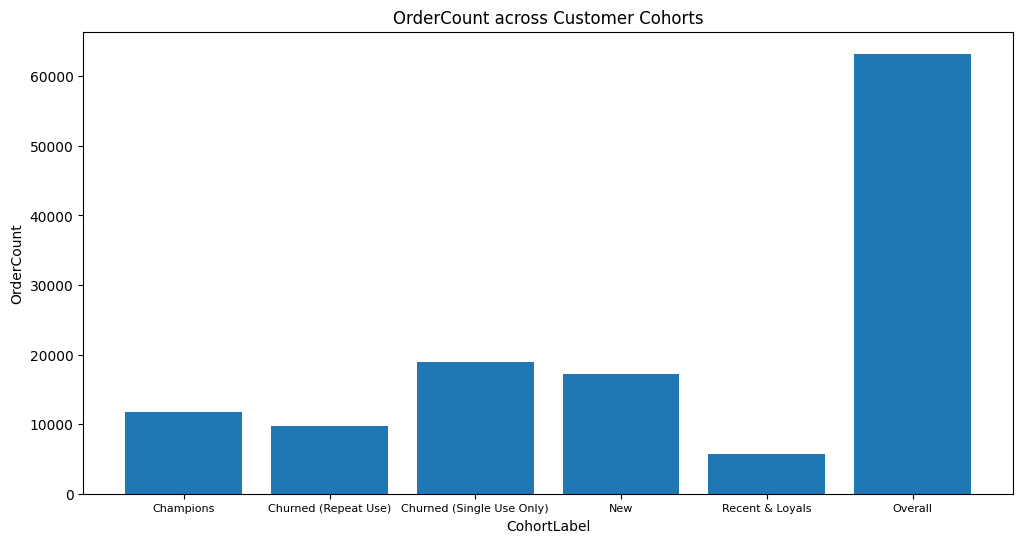

In [123]:
column_to_plot = 'OrderCount'
x_labels = segstats['CohortLabel']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, segstats[column_to_plot])
plt.xlabel('CohortLabel')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Customer Cohorts')
plt.xticks(fontsize=8)
plt.show()